# Классификация текста с помощью трансформера BERT

Оригинальная идея подчерпнута отсюда https://www.kaggle.com/c/learn-ai-bbc и отсюда https://habr.com/ru/post/655517/


### Импорт библиотек

In [93]:
import re
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

import torch
import transformers
import torch.nn as nn
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from bs4 import BeautifulSoup
import pickle


tqdm.pandas()

device = torch.device('cuda')
print(device)

cuda


### Чтение нашего датасета, состоящего описаний категорий и ТНВЭД


In [78]:
df = pd.read_csv('dataset.csv', index_col=0)
display(df)

,OPISANIE_CLEAN,TNVED,TNVED2
0,части принадлежности аппаратуры поз 9025 военн...,9025,90
1,трансформаторы мощностью 1 ква 16 ква лом элек...,8504,85
2,клапаны запорные стали военного назначения,8481,84
3,устройства сигнализационные охранные устройств...,8531,85
4,вещества поверхностно активные органические ан...,3402,34
...,...,...,...
4177894,минеральное моторное масло всесезонное дизельн...,2710,27
4177895,синтетическое моторное масло всесезонное дизел...,3403,34
4177896,синтетическое моторное масло всесезонное дизел...,3403,34
4177897,масло трансмиссионное синтетической основе сод...,3403,34


In [79]:
df2 = pd.read_csv('tnved.csv', index_col=0)
df2 = df2.rename(columns={'TNVED_SHORT': 'TNVED'})
display(df2)

,OPISANIE_CLEAN,TNVED,TNVED2
,,,
1,лошади живые чистопородные племенные животные,101,1
2,лошади ослы мулы лошаки живые прочие,101,1
3,прочие лошади живые прочие,101,1
4,ослы живые,101,1
5,прочие мулы лошаки живые,101,1
...,...,...,...
12318,подлинники гравюр эстампов литографий,9702,97
12319,подлинники скульптур статуэток любых материалов,9703,97
12320,марки почтовые марки госпошлин знаки почтовой ...,9704,97


In [204]:
df_train = df.sample(frac=.05, random_state=111, weights='TNVED')
df_train = pd.concat([df_train,df2])
display(df_train)

,OPISANIE_CLEAN,TNVED,TNVED2
2554207,устройства вычислительных машин отладочная пла...,8471,84
706914,бюстгальтеры женские рост 185 см обхват груди ...,6212,62
1817482,электрические части оборудования,8548,85
3212186,пиловочник осиновый тополь дрожащий осина popu...,4403,44
1231522,принадлежности рыбной ловли блесна вращающаяся...,9507,95
...,...,...,...
12318,подлинники гравюр эстампов литографий,9702,97
12319,подлинники скульптур статуэток любых материалов,9703,97
12320,марки почтовые марки госпошлин знаки почтовой ...,9704,97
12321,коллекции предметы коллекционирования зоологии...,9705,97


In [205]:
# delete small classes
df_train = df_train[df_train.groupby('TNVED').TNVED.transform('count')>40].copy() 
display(df_train)


,OPISANIE_CLEAN,TNVED,TNVED2
2554207,устройства вычислительных машин отладочная пла...,8471,84
706914,бюстгальтеры женские рост 185 см обхват груди ...,6212,62
1817482,электрические части оборудования,8548,85
3212186,пиловочник осиновый тополь дрожащий осина popu...,4403,44
1231522,принадлежности рыбной ловли блесна вращающаяся...,9507,95
...,...,...,...
12311,моноопоры двуноги треноги аналогичные изделия ...,9620,96
12312,моноопоры двуноги треноги аналогичные изделия ...,9620,96
12313,моноопоры двуноги треноги аналогичные изделия ...,9620,96
12314,моноопоры двуноги треноги аналогичные изделия ...,9620,96


In [206]:
all_tnved = np.unique(df_train['TNVED'])
print(len(all_tnved), all_tnved)
with open('new_keys.pickle', 'wb') as handle:
    pickle.dump(tokens_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

474 [ 203  207  302  303  304  305  306  307  403  406  602  603  709  805
  806  808  810 1006 1104 1515 1602 1604 1605 1701 1704 1806 1901 1902
 1905 2001 2004 2005 2007 2008 2009 2101 2103 2106 2202 2203 2204 2208
 2309 2701 2710 2711 2803 2836 2903 2905 2915 2918 2921 2922 2933 3002
 3004 3005 3006 3102 3105 3204 3206 3208 3209 3214 3215 3301 3302 3303
 3304 3305 3306 3307 3401 3402 3403 3405 3505 3506 3808 3811 3814 3820
 3822 3824 3901 3902 3903 3904 3905 3906 3907 3909 3910 3916 3917 3918
 3919 3920 3921 3922 3923 3924 3925 3926 4002 4008 4009 4010 4011 4012
 4015 4016 4202 4203 4302 4303 4401 4403 4407 4408 4409 4410 4411 4412
 4415 4418 4419 4420 4421 4602 4703 4801 4802 4804 4805 4810 4811 4818
 4819 4820 4821 4823 4901 4911 5205 5208 5401 5402 5407 5514 5601 5603
 5607 5702 5703 5705 5801 5806 5903 5911 6001 6006 6101 6102 6103 6104
 6105 6106 6107 6108 6109 6110 6111 6112 6113 6114 6115 6116 6117 6201
 6202 6203 6204 6205 6206 6207 6208 6209 6210 6211 6212 6214 6216 6217
 6

In [207]:
print(int(np.where(all_tnved == 9620)[0]))

473


Make new keys

In [208]:
df_train['target']=df_train['TNVED'].apply(lambda x: int(np.where(all_tnved == x)[0]))

In [209]:
display(df_train)

,OPISANIE_CLEAN,TNVED,TNVED2,target
2554207,устройства вычислительных машин отладочная пла...,8471,84,357
706914,бюстгальтеры женские рост 185 см обхват груди ...,6212,62,192
1817482,электрические части оборудования,8548,85,411
3212186,пиловочник осиновый тополь дрожащий осина popu...,4403,44,119
1231522,принадлежности рыбной ловли блесна вращающаяся...,9507,95,463
...,...,...,...,...
12311,моноопоры двуноги треноги аналогичные изделия ...,9620,96,473
12312,моноопоры двуноги треноги аналогичные изделия ...,9620,96,473
12313,моноопоры двуноги треноги аналогичные изделия ...,9620,96,473
12314,моноопоры двуноги треноги аналогичные изделия ...,9620,96,473


### Загрузка претренированной модели

In [185]:
bert = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

### Разбиение выборок на текст и таргет

In [ ]:
with open('X_train.pickle', 'rb') as handle:
    X_train = pickle.load(handle)
with open('y_train.pickle', 'rb') as handle:
    y_train = pickle.load(handle)
with open('X_test.pickle', 'rb') as handle:
    X_test = pickle.load(handle)
with open('y_test.pickle', 'rb') as handle:
    y_test = pickle.load(handle)

In [210]:
X = df_train['OPISANIE_CLEAN'].astype(str)
y = df_train['target'].astype(int)

X_train, y_train = X,y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

print(np.unique(y_train).shape)
print(np.unique(y_test).shape)

(474,)
(474,)


In [211]:
with open('X_train.pickle', 'wb') as handle:
    pickle.dump(X_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('y_train.pickle', 'wb') as handle:
    pickle.dump(y_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('X_test.pickle', 'wb') as handle:
    pickle.dump(X_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('y_test.pickle', 'wb') as handle:
    pickle.dump(y_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

График длин текстов. Он поможет определить оптимальную длину последовательности токенов, чтобы избежать разреженных векторов.

<AxesSubplot:>

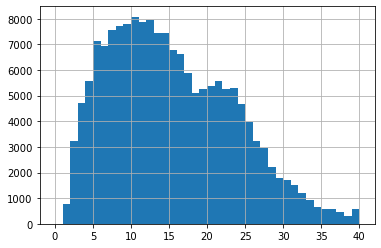

In [212]:
seq_len = [len(str(i).split()) for i in X_train]
pd.Series(seq_len).hist(bins = 40, range =(0,40))

### Токенизация текста
Берем длину 15

In [9]:
with open('tokens_train.pickle', 'rb') as handle:
    tokens_train = pickle.load(handle)
    
with open('tokens_test.pickle', 'rb') as handle:
    tokens_test = pickle.load(handle)

In [213]:
token_len = 15

tokens_train = tokenizer.batch_encode_plus(
    X_train.values,
    max_length = token_len,
    padding = 'max_length',
    truncation = True
)
tokens_test = tokenizer.batch_encode_plus(
    X_test.values,
    max_length = token_len,
    padding = 'max_length',
    truncation = True
)

In [214]:
with open('tokens_train.pickle', 'wb') as handle:
    pickle.dump(tokens_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('tokens_test.pickle', 'wb') as handle:
    pickle.dump(tokens_test, handle, protocol=pickle.HIGHEST_PROTOCOL)


### Создание датасета для обучения из токенов

In [215]:
batch_size = 4


train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.values)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.values)

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

test_data =  TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = batch_size)

In [ ]:
print(test_data[0])

### Вместо обучения всего BERT добавим слой для классификации

In [216]:
for param in bert.parameters():
    param.requires_grad = False

class BERT_Arch(nn.Module):
    
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,474)
        self.softmax = nn.LogSoftmax(dim = 1)
    
    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask = mask, return_dict = False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

### Загрузка модели в GPU

In [15]:
torch.cuda.empty_cache()

In [217]:
model = BERT_Arch(bert)

model = model.to(device)
from torch.optim import AdamW

optimizer = AdamW(model.parameters())

### Нормализация весов в зависимости от соотношения классов в выборке трейна

In [218]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights += 0.1

#print(class_weights)

weights = torch.tensor(class_weights, dtype = torch.float)
weights = weights.to(device)
#cross_entropy = nn.CrossEntropyLoss()
cross_entropy = nn.NLLLoss(weight=weights)
epochs = 20

/home/eugene/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215

Функция для наглядного обучения модели

In [219]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    
    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [r.to(device) for r in batch]
        sent_id,mask,labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        #print(loss)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
        
    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    return avg_loss, total_preds

Функция для тестирования модели

In [220]:
def evaluate():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []

    for step, batch in tqdm(enumerate(test_dataloader), total = len(test_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            #labels= labels.unsqueeze(1)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(test_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    
    return avg_loss, total_preds

Обучение новых слоев для задачи классификации

In [221]:
best_test_loss = float('inf')

train_losses = []
test_losses = []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))
    
    train_loss, _ = train()
    test_loss, _ = evaluate()
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Test loss: {test_loss:.3f}')
    
    
def train_acc():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []
    total_acc_test = 0

    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            #labels= labels.unsqueeze(1)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            
            test_labels = labels.to(device)
            acc = (preds.argmax(dim=1) == test_labels).sum().item()
            total_acc_test += acc            
            
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
            


    avg_loss = total_loss / len(test_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    print(f'Test Accuracy: {total_acc_test / len(total_preds): .3f}')
    return avg_loss, total_preds

aa,bb = train_acc()    
    
def acc():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []
    total_acc_test = 0

    for step, batch in tqdm(enumerate(test_dataloader), total = len(test_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            #labels= labels.unsqueeze(1)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            
            test_labels = labels.to(device)
            acc = (preds.argmax(dim=1) == test_labels).sum().item()
            total_acc_test += acc            
            
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
            


    avg_loss = total_loss / len(test_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    print(f'Test Accuracy: {total_acc_test / len(total_preds): .3f}')
    return avg_loss, total_preds

a,b = acc()


 Epoch1 / 20


100%|██████████| 10594/10594 [02:59<00:00, 58.88it/s]



Training loss: 4.244
Test loss: 3.094

 Epoch2 / 20


100%|██████████| 10594/10594 [02:58<00:00, 59.29it/s]



Training loss: 3.448
Test loss: 2.888

 Epoch3 / 20


100%|██████████| 10594/10594 [02:58<00:00, 59.25it/s]



Training loss: 3.286
Test loss: 2.885

 Epoch4 / 20


100%|██████████| 10594/10594 [02:59<00:00, 59.10it/s]



Training loss: 3.195
Test loss: 2.674

 Epoch5 / 20


100%|██████████| 10594/10594 [02:59<00:00, 59.13it/s]



Training loss: 3.146
Test loss: 2.545

 Epoch6 / 20


100%|██████████| 10594/10594 [02:59<00:00, 59.12it/s]



Training loss: 3.087
Test loss: 2.513

 Epoch7 / 20


100%|██████████| 10594/10594 [02:59<00:00, 59.15it/s]



Training loss: 3.048
Test loss: 2.477

 Epoch8 / 20


100%|██████████| 10594/10594 [02:58<00:00, 59.32it/s]



Training loss: 3.006
Test loss: 2.543

 Epoch9 / 20


100%|██████████| 10594/10594 [02:58<00:00, 59.28it/s]



Training loss: 2.985
Test loss: 2.482

 Epoch10 / 20


100%|██████████| 10594/10594 [02:59<00:00, 59.15it/s]



Training loss: 2.962
Test loss: 2.401

 Epoch11 / 20


100%|██████████| 10594/10594 [02:58<00:00, 59.21it/s]



Training loss: 2.939
Test loss: 2.423

 Epoch12 / 20


100%|██████████| 10594/10594 [02:58<00:00, 59.32it/s]



Training loss: 2.919
Test loss: 2.434

 Epoch13 / 20


100%|██████████| 10594/10594 [02:58<00:00, 59.40it/s]



Training loss: 2.907
Test loss: 2.506

 Epoch14 / 20


100%|██████████| 10594/10594 [02:58<00:00, 59.24it/s]



Training loss: 2.899
Test loss: 2.330

 Epoch15 / 20


100%|██████████| 10594/10594 [02:59<00:00, 59.08it/s]



Training loss: 2.884
Test loss: 2.409

 Epoch16 / 20


100%|██████████| 10594/10594 [02:46<00:00, 63.57it/s]



Training loss: 2.875
Test loss: 2.420

 Epoch17 / 20


100%|██████████| 10594/10594 [02:58<00:00, 59.23it/s]



Training loss: 2.867
Test loss: 2.526

 Epoch18 / 20


100%|██████████| 10594/10594 [02:58<00:00, 59.31it/s]



Training loss: 2.859
Test loss: 2.414

 Epoch19 / 20


100%|██████████| 10594/10594 [02:58<00:00, 59.20it/s]



Training loss: 2.861
Test loss: 2.359

 Epoch20 / 20


100%|██████████| 10594/10594 [02:58<00:00, 59.21it/s]



Training loss: 2.842
Test loss: 2.301


100%|██████████| 42375/42375 [12:04<00:00, 58.47it/s]


Test Accuracy:  0.554


100%|██████████| 10594/10594 [03:00<00:00, 58.59it/s]

Test Accuracy:  0.548


Загружаем лучшую модель для предсказания

In [222]:
model.eval()

BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

In [ ]:
#path = '474_v2_saved_weights.pt'
#model.load_state_dict(torch.load(path))
#model.eval()

### Предсказываем


In [223]:
def predict_dataloader(predict_dataloader):
    total_preds = []
    total_labels = []
    
    for step, batch in tqdm(enumerate(predict_dataloader), total = len(predict_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            preds = preds.detach().cpu().numpy()    
            preds = preds.argmax(axis=1)
            labels = labels.cpu().numpy()
            total_preds.append(preds)
            total_labels.append(labels)
            
    return total_preds, total_labels


def predict_df(df):
    df = df.copy()
    batch_size = 1
    tokens_predict = tokenizer.batch_encode_plus(
        df['OPISANIE_CLEAN'].values,
        max_length = 15,
        padding = 'max_length',
        truncation = True
    )
    
    total_preds = []
    
    predict_seq = torch.tensor(tokens_predict['input_ids'])
    predict_mask = torch.tensor(tokens_predict['attention_mask'])
    predict_data =  TensorDataset(predict_seq, predict_mask)
    predict_sampler = SequentialSampler(predict_data)
    predict_dataloader = DataLoader(predict_data, sampler = predict_sampler, batch_size = batch_size)
    
    
    for step, batch in tqdm(enumerate(predict_dataloader), total = len(predict_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            preds = preds.detach().cpu().numpy()    
            preds = np.argmax(preds)
            total_preds.append(preds)
    df['target'] = total_preds
    return df

#pred_df = predict_df(test_df)
#display(pred_df)

a, b = predict_dataloader(test_dataloader)

a = np.hstack(a)
b = np.hstack(b)

for x in zip(a,b):
    print(x[0], x[1])

100%|██████████| 10594/10594 [02:16<00:00, 77.46it/s]


274 274
365 366
455 455
63 61
420 379
323 323
420 420
267 267
420 420
110 110
390 357
173 173
404 404
96 100
173 169
400 377
56 56
400 400
384 383
170 168
231 459
366 400
365 365
364 360
372 369
114 114
189 189
300 354
143 78
274 274
379 441
110 110
114 114
410 410
472 472
393 393
171 169
184 190
274 273
181 181
110 110
267 364
444 406
366 420
298 423
453 453
133 133
364 420
184 184
167 167
310 455
204 204
118 119
355 336
120 122
109 105
357 357
372 400
310 420
416 416
40 40
439 138
184 167
297 297
420 420
420 100
393 357
183 181
93 92
108 96
93 75
151 198
420 420
233 233
310 366
236 236
400 400
365 366
258 274
379 379
267 267
281 282
274 274
452 452
110 420
174 172
173 168
330 330
182 184
274 267
3 1
205 205
98 98
380 380
267 420
12 36
444 445
416 417
439 441
380 380
377 377
166 174
267 311
326 398
396 396
366 366
110 110
384 384
457 457
189 189
334 402
407 407
415 420
184 184
419 231
364 377
455 455
274 274
325 372
416 416
453 453
173 173
416 436
366 323
405 405
184 167
267 267
182 1

212 105
323 324
232 232
233 233
110 110
416 417
173 173
84 84
333 333
28 9
217 217
422 422
444 385
404 431
274 274
205 205
167 167
179 179
58 80
205 205
274 274
366 366
407 407
420 420
321 379
357 357
153 445
380 380
326 326
143 143
380 402
172 171
357 357
420 420
375 396
336 336
235 236
467 307
383 354
103 105
365 265
166 173
309 309
420 420
405 405
223 223
171 171
420 446
330 330
167 167
391 401
310 310
342 440
316 316
420 366
110 110
420 420
407 407
44 76
326 364
172 173
342 98
172 172
184 184
420 420
385 385
330 330
267 340
326 330
398 398
385 385
422 422
372 387
230 230
457 395
267 267
400 373
333 333
420 423
120 120
40 40
184 184
173 173
364 372
420 420
400 400
420 464
166 166
0 1
298 357
44 81
400 400
173 173
205 205
431 431
364 420
420 420
420 420
173 173
420 330
400 400
420 267
323 420
420 420
340 332
420 420
462 462
400 372
98 95
420 420
167 171
25 25
258 258
271 446
431 431
217 102
420 420
150 150
310 310
184 184
241 241
330 330
357 385
44 76
48 48
321 321
364 324
410 410
40

167 167
175 207
325 420
328 231
323 143
215 215
167 167
166 166
119 67
355 355
365 365
1 1
202 202
181 181
110 110
325 357
267 267
44 319
447 447
267 321
205 204
321 321
391 385
420 420
108 108
184 188
182 173
267 258
206 206
110 110
420 309
170 170
420 420
455 104
354 402
300 300
271 344
110 110
330 330
267 267
379 400
267 267
434 457
105 105
420 420
410 410
402 402
434 423
192 184
420 420
320 320
310 367
420 420
364 366
114 114
105 105
330 330
380 380
310 217
114 184
400 400
239 309
420 420
109 109
420 420
170 164
321 321
113 46
453 453
457 457
444 445
103 451
400 400
376 332
357 357
279 279
300 300
321 321
110 110
364 319
233 233
120 119
173 165
384 384
258 258
192 191
420 420
330 330
40 40
420 323
364 325
217 217
372 372
146 146
420 420
344 377
248 267
298 298
372 357
295 295
372 400
379 420
93 88
300 300
96 96
364 420
380 380
462 462
333 333
420 420
120 120
274 274
205 205
56 435
135 135
326 326
113 113
407 407
400 400
420 310
267 464
400 105
374 420
183 167
420 420
400 400
274 40

170 164
320 319
175 175
421 421
92 82
120 120
338 458
420 420
105 105
364 256
79 79
310 107
105 420
254 264
420 446
298 464
267 267
420 420
205 205
17 213
365 367
440 440
365 365
384 329
172 178
259 268
405 405
384 329
205 205
323 323
2 2
364 279
357 372
120 120
357 357
393 357
310 268
444 446
346 346
267 267
330 330
405 296
161 161
447 447
173 167
404 404
420 230
416 416
226 202
447 447
318 468
258 258
390 385
110 110
366 366
324 324
435 435
457 457
305 305
366 366
86 254
267 267
325 439
309 267
461 461
364 382
268 268
310 420
405 405
364 325
297 400
457 457
274 267
241 241
457 224
259 310
282 283
354 352
461 461
142 141
445 445
427 340
446 298
174 174
410 410
366 366
114 114
330 330
322 44
400 400
226 226
376 384
420 364
357 364
338 342
366 420
283 283
372 384
119 119
321 366
372 372
253 244
274 274
98 93
269 269
310 310
435 433
379 379
268 268
113 380
404 404
365 365
96 96
323 370
336 336
366 366
420 420
405 405
396 404
93 85
404 404
137 137
402 402
359 279
9 9
233 231
439 445
173 1

386 386
113 113
231 310
439 443
374 375
357 385
38 38
366 420
400 407
110 110
416 416
99 99
289 289
420 325
1 1
103 105
443 420
378 366
420 420
310 252
439 441
340 420
300 466
354 435
420 420
105 469
184 162
326 326
357 445
114 181
167 167
274 382
369 369
377 359
364 364
420 420
404 404
364 325
135 136
420 332
2 2
177 163
357 357
420 420
366 111
416 416
364 364
388 385
325 369
392 392
105 105
173 178
44 76
420 420
455 129
274 267
435 75
407 407
267 267
393 393
165 165
231 457
281 281
251 242
297 380
426 445
114 114
233 457
206 206
446 439
274 267
357 405
372 372
135 135
173 173
366 105
101 101
384 386
291 291
410 113
206 204
461 461
244 244
181 182
165 186
328 326
365 265
441 324
110 110
420 453
447 447
274 113
167 167
403 400
183 181
370 370
359 372
420 420
120 120
267 366
405 405
267 267
206 206
56 56
174 174
440 440
446 44
420 420
439 440
420 420
274 274
113 113
177 169
231 420
364 367
125 120
365 365
347 347
400 407
400 386
231 232
416 416
372 400
324 324
373 373
425 426
287 287
42

400 400
267 267
384 298
274 274
397 397
325 325
386 386
190 71
457 457
459 459
274 274
336 76
435 437
394 402
405 402
84 435
364 373
33 37
435 84
372 402
319 319
379 453
357 357
172 177
44 76
365 365
405 405
219 338
384 375
206 113
233 226
267 267
105 105
244 245
38 38
357 357
39 39
17 17
170 164
301 354
274 420
366 420
420 420
357 385
114 114
252 254
459 459
310 274
23 150
105 217
267 267
420 420
59 59
268 354
326 326
389 389
120 120
182 182
446 441
206 205
364 364
167 167
400 105
113 113
413 413
310 310
369 369
364 364
204 204
354 457
215 254
364 364
372 405
184 182
267 267
364 72
274 273
420 420
420 420
457 457
267 310
420 453
310 315
205 205
105 105
183 167
173 167
70 114
120 120
364 446
92 99
400 407
447 447
420 420
457 457
380 380
262 262
347 349
244 246
30 301
407 407
267 267
80 105
340 420
267 267
407 400
330 330
366 366
385 385
215 215
357 357
325 357
401 401
324 324
110 110
301 296
403 403
420 420
400 400
321 321
364 364
204 204
310 310
364 364
267 267
366 464
274 274
400 400

379 379
326 326
274 267
374 374
205 204
333 333
268 268
355 355
364 373
186 186
372 406
300 300
384 328
455 455
205 205
420 400
76 76
298 423
182 182
40 40
310 310
133 133
457 457
379 468
420 420
110 420
400 404
405 405
215 292
394 402
376 376
73 384
416 416
105 105
325 325
325 325
50 81
384 384
407 384
326 326
457 457
189 174
375 372
318 270
404 404
184 184
274 274
447 404
183 183
120 120
420 268
3 5
310 384
256 256
172 180
175 178
384 384
96 118
310 267
420 420
63 50
420 420
41 41
63 63
185 185
394 385
420 420
229 229
274 274
69 69
309 309
357 357
425 385
145 79
385 385
390 390
364 364
405 405
310 455
367 367
205 206
108 108
400 407
99 95
205 205
400 407
180 180
385 385
407 384
357 357
440 455
455 455
190 190
438 297
267 258
181 185
27 344
334 334
401 400
11 11
364 364
420 420
455 455
217 455
123 123
441 407
310 310
324 324
271 271
120 120
461 461
420 423
172 173
410 410
113 367
233 471
447 447
267 267
226 455
420 309
420 380
181 181
281 281
277 102
355 324
410 384
420 420
322 322
46

354 402
173 173
184 167
323 323
25 25
451 451
170 183
118 118
366 366
447 447
274 274
365 366
114 105
400 325
366 420
420 420
403 444
330 330
59 60
441 403
420 420
135 135
404 404
184 182
279 364
404 404
289 280
366 274
92 374
365 365
380 380
274 274
405 405
251 251
457 457
281 300
375 375
357 385
73 182
459 459
274 366
439 439
192 171
357 400
364 420
420 420
118 118
455 455
420 420
125 125
325 369
405 405
400 400
205 205
390 274
120 120
372 235
420 420
206 206
400 400
446 330
364 420
274 267
414 301
269 269
364 364
405 405
472 472
383 383
340 340
325 325
440 439
384 384
114 114
357 385
420 440
70 70
274 274
109 109
416 416
93 456
404 404
258 258
109 109
206 206
114 114
405 372
268 268
405 405
427 457
420 400
397 397
364 380
354 390
166 183
120 120
360 367
416 416
274 274
405 405
170 166
103 105
420 420
420 309
167 167
3 2
167 173
284 284
140 140
267 267
120 455
3 2
436 436
400 400
274 267
323 330
182 182
274 274
330 105
298 298
420 420
387 389
267 362
114 172
317 317
274 274
310 309
2

439 426
368 402
259 274
267 310
184 184
384 384
114 114
44 384
431 393
268 366
457 457
384 384
64 64
274 274
205 205
114 140
364 364
366 420
435 437
447 402
444 444
183 183
447 312
289 288
397 397
342 342
184 184
389 357
420 420
400 407
289 289
321 321
113 113
146 146
440 440
400 402
3 4
357 405
375 375
172 164
420 420
44 44
105 105
288 289
375 375
206 207
309 309
420 420
457 457
274 267
274 310
298 333
1 1
108 108
330 330
369 372
113 113
420 420
330 330
310 310
397 396
420 284
134 136
400 400
396 396
400 400
420 380
365 365
372 446
84 84
99 159
364 323
420 420
404 289
384 384
424 424
420 420
313 313
405 405
375 96
274 274
420 366
377 377
443 420
310 400
405 405
182 182
416 416
459 459
400 401
76 76
34 34
372 400
400 400
205 205
364 401
183 166
185 164
203 203
439 325
184 184
105 105
420 420
173 173
420 420
401 401
70 70
258 258
274 273
360 324
257 257
420 346
321 330
274 383
170 173
186 184
225 225
372 373
173 167
167 167
248 247
267 267
385 386
331 331
80 75
324 324
365 365
420 407
4

267 267
184 184
172 168
119 341
357 357
357 389
74 136
182 182
76 44
223 223
366 366
455 455
184 171
446 386
113 113
365 365
258 258
121 121
375 325
364 364
267 267
366 366
119 120
179 179
341 400
435 435
420 267
3 21
268 268
364 371
307 306
274 274
416 416
427 428
364 82
461 461
330 364
310 310
204 204
113 105
181 181
325 349
405 405
226 226
402 359
321 321
128 261
372 385
31 113
200 102
420 325
357 357
167 167
184 184
455 455
34 34
184 184
184 184
120 120
440 441
357 385
113 113
405 405
431 386
400 400
84 47
125 125
326 326
447 300
384 384
110 110
386 386
281 281
420 420
375 375
183 183
268 268
435 435
383 383
56 56
364 364
173 172
192 180
310 310
318 318
254 252
364 325
185 173
364 366
120 120
434 434
420 420
267 267
366 366
400 384
396 396
56 56
420 420
182 182
387 389
40 40
105 271
385 385
421 421
184 193
105 105
420 420
166 166
346 440
410 410
417 379
431 393
455 439
364 364
166 178
365 365
405 405
364 324
182 182
453 386
124 123
170 168
273 273
248 254
205 205
416 421
274 267
45

235 105
326 325
205 204
366 366
183 183
397 397
400 400
180 192
420 407
420 420
106 456
384 384
310 310
105 105
413 413
421 421
103 103
325 400
267 314
374 420
256 256
253 255
374 407
267 267
289 140
182 182
400 400
420 420
267 267
256 254
372 401
182 182
267 373
182 182
261 261
212 212
268 268
184 186
139 139
420 394
404 404
259 386
439 439
124 123
184 184
357 393
400 446
182 182
372 372
184 167
405 405
309 309
364 364
407 407
330 330
40 40
21 20
366 366
374 400
420 423
33 32
34 34
205 205
447 447
385 385
420 420
457 457
92 106
326 325
357 385
357 385
325 325
267 267
120 120
357 357
364 346
413 413
400 400
372 380
131 142
251 251
358 358
400 400
223 223
182 191
439 364
30 28
310 113
416 416
334 334
102 100
396 396
416 416
76 76
380 380
407 407
395 380
2 2
324 325
118 118
142 140
274 274
167 184
420 420
364 364
401 440
173 173
184 167
364 330
404 404
416 417
405 405
342 342
407 407
400 400
173 173
420 320
309 366
365 293
384 332
198 158
447 447
404 404
120 120
433 444
435 435
389 389
4

380 380
310 401
300 310
166 166
172 178
357 357
301 362
184 183
326 328
420 420
357 357
364 364
400 400
453 453
414 108
235 216
268 268
365 366
274 267
447 447
420 400
364 364
385 385
318 269
297 267
120 120
403 384
108 267
446 401
267 258
407 407
340 267
405 405
173 308
455 455
267 267
206 205
167 167
205 205
364 289
434 434
364 364
182 182
437 178
364 420
364 372
420 420
267 267
166 178
289 285
114 114
300 300
461 103
400 400
66 63
259 259
215 214
379 379
366 366
396 396
374 428
400 400
119 119
328 328
420 380
420 420
431 431
400 407
364 105
289 289
3 21
119 120
357 407
439 372
183 183
300 126
274 105
274 310
325 325
39 39
366 267
420 113
357 359
184 184
389 389
189 174
180 162
124 124
267 267
323 362
120 120
310 268
405 405
420 420
400 400
420 401
274 301
420 98
400 400
447 447
229 99
364 364
407 384
324 323
435 70
272 105
110 110
323 365
380 380
108 113
166 167
102 105
267 267
321 327
416 416
453 453
92 92
364 105
420 420
435 435
202 271
364 364
96 364
420 420
364 331
173 165
102 1

310 279
184 184
366 440
113 380
455 455
372 372
173 173
184 184
59 59
70 470
298 298
322 330
167 173
364 471
416 416
364 321
267 267
440 440
125 125
354 105
256 256
364 364
147 147
321 321
420 420
120 119
446 376
114 469
25 25
452 452
310 65
462 462
134 137
166 166
284 289
330 330
114 114
166 168
364 330
400 400
431 431
420 420
119 119
205 205
321 324
357 357
405 405
338 109
420 420
420 420
393 393
297 359
108 108
372 372
420 420
183 166
289 420
420 267
420 330
231 231
108 108
274 274
364 400
310 108
173 173
300 298
44 76
274 261
365 365
171 171
420 420
289 330
321 321
125 125
274 273
297 385
420 420
310 310
375 364
118 118
113 113
467 466
384 384
374 374
233 233
274 420
267 314
110 113
34 41
103 103
310 402
109 149
236 236
172 177
435 435
267 267
300 300
404 400
96 330
346 346
375 375
385 385
396 396
364 330
98 98
166 166
330 330
55 441
354 402
267 267
254 254
43 43
400 400
298 298
372 385
453 453
364 330
332 332
204 206
358 113
108 113
182 184
106 140
60 60
121 121
267 267
267 267
37

25 25
105 105
289 455
120 120
120 119
328 328
330 330
105 105
400 400
230 330
344 377
416 416
364 272
463 267
365 366
439 440
173 202
206 456
244 244
120 120
445 435
366 291
425 385
134 181
384 384
166 173
289 457
230 230
267 263
44 44
179 179
108 109
340 340
472 472
166 167
355 457
321 321
416 416
103 105
267 267
108 108
267 354
420 420
110 110
173 173
193 193
373 373
304 464
246 246
323 267
401 400
296 298
33 56
420 420
405 405
181 181
364 258
172 172
366 105
110 110
400 400
289 274
178 178
310 314
110 333
389 389
364 364
361 366
379 321
267 420
364 355
284 284
133 121
267 274
394 325
354 267
192 184
330 330
117 117
205 205
325 386
305 305
274 407
181 181
303 303
108 108
364 364
70 70
110 110
455 310
251 251
375 372
330 330
173 173
365 365
99 56
396 396
302 300
416 416
274 102
330 330
364 268
298 298
98 363
56 56
366 366
437 435
109 109
167 167
74 74
113 113
453 453
119 119
105 105
105 105
400 400
103 325
365 365
127 458
45 45
400 400
267 267
339 340
364 258
401 401
324 324
121 124
2

310 105
2 7
364 364
253 246
403 403
420 366
364 96
354 354
50 50
420 420
364 420
366 407
256 256
394 394
330 330
113 105
357 357
55 84
416 416
420 420
384 400
364 105
173 173
209 209
258 315
226 226
420 420
425 428
197 197
310 217
369 369
310 310
258 257
186 191
420 99
323 323
267 267
455 455
420 220
267 268
365 265
403 400
105 105
274 274
400 400
326 326
364 420
420 105
384 446
105 105
310 296
420 420
267 263
364 364
336 338
375 375
453 453
434 423
120 120
379 446
400 402
183 186
267 267
298 355
323 323
205 455
420 420
400 407
202 195
274 274
301 258
342 330
325 325
244 244
184 167
420 420
453 453
364 267
244 244
420 366
310 310
321 321
184 184
310 333
2 2
119 120
373 373
400 407
120 120
401 407
217 202
334 334
267 258
300 401
274 274
420 379
55 224
372 372
391 391
300 300
383 383
274 274
98 331
400 104
405 405
459 459
173 167
274 267
64 61
446 401
404 385
310 311
257 256
446 446
336 338
357 405
239 239
267 267
170 173
420 267
310 271
422 422
357 389
400 400
357 357
420 420
74 74
372 

173 173
364 364
101 103
407 407
434 434
300 266
453 453
310 420
267 315
173 209
198 198
379 320
456 456
304 304
320 319
381 386
435 423
310 310
445 445
274 274
164 170
184 184
173 176
439 330
135 135
400 407
274 267
182 182
420 420
366 445
461 209
461 461
366 265
425 385
434 434
457 457
267 330
421 421
364 364
359 405
400 400
387 387
388 386
396 396
318 318
84 84
420 400
184 184
330 330
193 184
375 105
167 167
307 307
459 460
400 400
298 334
427 105
453 453
142 142
267 267
184 184
405 405
184 186
420 360
267 267
96 96
321 407
364 325
372 372
416 416
271 308
420 420
289 289
297 297
420 412
384 331
420 394
369 369
231 231
357 357
256 256
380 457
328 328
183 183
267 267
119 120
295 435
391 391
408 408
404 404
385 386
390 390
394 98
128 130
301 340
325 319
407 407
298 371
416 416
419 412
385 385
310 402
355 355
253 254
33 33
109 109
385 385
300 300
402 402
420 420
455 464
447 447
324 324
171 171
167 171
361 85
183 183
320 320
439 444
267 267
215 215
391 394
183 181
92 63
375 396
402 354
43

420 369
205 205
393 393
457 457
420 420
114 114
206 206
235 398
440 440
375 375
204 204
55 85
181 181
336 336
410 410
172 172
310 402
420 420
110 206
268 364
153 147
324 324
46 46
415 367
340 367
384 296
365 44
364 364
341 341
105 105
364 456
173 173
267 267
416 416
108 108
50 52
420 284
183 166
380 380
274 274
380 380
11 11
228 236
103 105
400 400
206 206
108 108
310 310
379 441
325 324
44 76
330 330
103 102
300 300
289 420
420 267
326 441
384 329
310 113
384 384
300 300
328 331
453 386
357 357
396 396
310 310
80 28
420 330
42 115
372 373
184 167
336 420
41 40
239 105
125 125
172 172
403 403
455 455
184 167
226 128
34 51
364 276
66 70
420 330
1 1
267 267
253 253
310 310
167 167
420 420
323 324
267 267
267 321
438 435
366 420
439 364
125 455
267 267
274 267
301 354
464 331
272 102
309 420
44 44
420 277
267 149
455 455
197 197
309 309
364 420
120 120
338 338
113 367
184 186
340 340
330 330
420 420
184 184
180 180
416 421
405 405
324 44
341 341
427 350
182 182
384 448
108 284
420 420
203

274 274
197 197
44 118
420 366
119 119
364 258
166 166
384 331
364 278
131 145
267 366
372 400
464 366
265 355
420 325
400 400
357 385
400 407
384 384
346 145
431 431
366 366
393 389
182 182
369 369
184 184
172 172
106 79
413 413
300 300
416 416
380 380
36 36
420 420
400 400
267 267
276 276
420 109
420 420
364 364
347 101
120 120
113 469
420 420
184 184
310 228
455 455
239 310
404 404
364 364
235 330
321 321
400 400
50 28
320 319
372 372
267 267
374 202
464 464
379 379
96 464
96 258
420 299
101 101
267 267
425 425
323 323
420 420
324 360
108 220
170 173
204 204
25 28
374 183
395 373
259 455
346 70
372 372
231 233
420 446
218 223
447 447
388 390
419 373
420 420
308 308
325 199
109 109
364 367
324 324
369 369
304 304
377 325
103 105
267 267
55 331
435 435
372 372
364 325
437 437
108 113
407 407
366 420
184 184
434 401
364 440
347 347
102 367
366 366
420 393
364 364
310 105
92 85
420 420
416 416
267 267
274 274
457 457
369 369
405 405
300 273
310 143
364 420
172 196
366 355
320 319
365 36

70 70
321 321
173 173
267 267
205 205
289 289
435 270
364 268
405 402
310 310
346 346
325 325
326 439
416 416
24 37
364 364
420 267
167 167
96 256
366 423
420 420
364 400
455 455
416 416
346 172
185 185
168 172
364 364
145 105
108 105
420 420
166 166
310 310
313 313
455 224
258 264
34 34
110 109
274 274
102 367
393 393
63 79
267 300
274 274
268 268
108 367
301 274
405 405
173 173
256 364
457 395
405 405
170 170
372 405
391 391
323 323
267 267
416 416
172 177
267 367
114 114
400 400
48 48
357 394
12 1
405 405
56 56
108 154
310 395
328 328
339 401
385 401
231 231
205 205
268 268
420 400
267 267
2 6
182 182
397 373
416 416
404 404
420 420
457 403
204 204
184 184
404 404
321 321
186 186
183 183
235 97
235 161
184 184
420 440
420 420
414 414
420 420
401 401
420 420
183 187
405 405
182 40
372 372
38 233
120 120
393 393
145 143
321 321
267 267
364 330
420 420
166 173
332 466
324 324
400 362
457 457
279 366
256 256
440 439
366 295
108 267
321 340
173 173
170 166
166 178
435 323
324 324
167 167

310 465
385 385
441 441
420 420
181 181
365 366
297 400
383 354
56 56
269 384
420 400
366 366
184 184
301 360
125 136
357 357
410 100
205 205
364 315
276 276
274 274
167 167
274 274
420 419
267 258
274 274
3 3
420 420
366 366
274 310
357 328
33 38
431 431
3 21
357 389
267 267
403 403
182 182
102 102
310 310
420 420
103 464
267 274
385 385
274 259
384 384
173 169
405 405
113 113
420 202
364 325
267 240
205 205
414 414
110 110
364 364
325 325
182 182
274 274
171 171
323 257
274 274
393 393
63 70
420 419
391 446
330 330
393 394
388 390
289 65
182 186
396 396
108 108
184 184
123 123
274 372
372 372
416 416
420 420
56 56
379 403
298 346
173 173
404 404
267 267
420 420
416 416
114 114
420 439
416 416
108 113
80 84
420 420
206 205
81 330
385 385
326 326
325 325
400 400
393 393
355 355
106 105
364 324
401 459
113 202
110 221
274 310
110 110
267 267
357 389
192 192
181 181
235 178
328 328
105 105
416 416
28 28
385 385
113 113
366 364
109 420
298 296
410 410
267 408
453 453
289 289
84 55
455 455

313 313
464 115
284 284
385 385
182 158
267 267
3 3
124 121
105 105
373 373
324 330
324 324
380 380
267 267
420 231
376 324
455 455
109 420
289 420
440 444
80 105
397 397
93 52
400 355
274 267
119 120
340 340
420 330
256 257
267 267
323 323
357 405
416 419
447 447
310 105
182 182
232 41
161 161
398 400
173 179
75 330
364 364
447 385
166 164
380 380
326 326
364 364
274 274
332 376
184 184
394 424
114 173
416 416
230 230
81 75
267 267
162 202
96 96
105 420
431 431
457 457
453 453
310 321
183 166
113 113
105 105
400 400
267 267
223 223
420 321
379 352
183 183
33 44
34 34
414 341
298 298
372 372
98 98
274 420
440 440
321 340
267 267
205 205
372 372
70 70
405 405
404 404
182 182
379 420
356 357
205 205
453 453
207 207
420 420
336 265
393 393
428 428
420 420
420 420
310 217
167 167
33 67
440 263
166 172
272 234
267 267
189 189
242 242
205 205
274 267
276 383
446 325
310 310
372 384
185 193
190 274
135 135
114 140
323 323
310 310
161 105
300 352
183 181
336 336
385 385
366 373
310 314
455 455

119 119
364 333
410 410
70 464
271 261
310 420
328 328
364 355
461 461
405 405
389 389
420 420
391 346
102 102
472 472
267 267
385 385
173 173
364 270
206 207
193 193
330 440
173 167
297 309
351 445
439 324
346 346
364 464
274 274
274 274
420 420
420 420
357 297
105 420
372 386
267 267
404 404
330 330
357 357
366 105
184 183
351 351
182 178
365 365
105 105
184 184
385 385
395 395
366 340
365 400
354 337
397 397
354 273
206 206
170 170
267 267
185 185
125 455
420 325
204 205
70 70
105 105
366 340
459 459
183 170
267 267
258 258
390 390
230 230
40 40
455 105
19 19
56 56
3 384
365 365
43 43
206 206
110 420
279 279
420 380
421 421
444 441
459 459
420 420
357 389
420 420
366 267
400 400
325 401
420 420
420 420
453 453
319 319
119 120
108 315
183 173
441 419
325 274
364 440
267 267
407 407
310 420
400 400
325 397
274 268
365 365
384 355
435 145
421 421
109 420
364 420
281 282
367 456
276 262
328 377
384 377
364 267
377 332
452 355
257 257
204 206
403 403
393 357
310 300
400 400
401 401
306 3

432 432
120 120
173 173
31 16
183 183
357 357
326 326
119 119
320 319
357 357
401 401
184 184
218 218
113 113
110 110
43 43
420 267
437 274
120 120
310 364
364 400
420 420
420 420
297 297
274 274
364 364
400 400
98 98
150 178
372 396
405 405
119 119
113 113
206 205
120 120
416 416
380 402
168 168
377 377
329 85
394 310
300 360
183 183
405 405
341 373
404 404
364 367
457 425
324 324
364 321
404 404
183 183
113 113
333 333
300 300
18 18
184 184
183 183
333 330
231 419
400 400
218 213
364 407
405 405
300 300
120 120
267 267
364 364
239 310
376 355
181 181
14 14
96 96
396 222
166 180
339 340
357 357
374 44
416 416
391 385
274 274
398 398
364 108
383 400
274 274
462 462
92 89
330 330
372 400
472 472
267 267
213 213
364 267
457 457
42 42
125 125
420 393
184 184
364 420
396 396
420 420
364 420
153 153
462 462
357 357
357 357
400 399
274 258
420 369
420 366
453 453
120 120
405 405
372 372
310 289
310 366
310 310
323 445
170 168
400 304
310 104
173 169
321 321
364 420
233 233
185 178
416 416
33

374 379
166 166
384 384
168 164
465 271
379 379
372 384
365 274
217 385
377 349
321 416
372 401
420 420
113 105
400 369
416 416
420 420
330 330
400 373
316 316
364 323
267 360
405 405
170 173
420 420
58 85
110 110
372 405
300 300
267 267
384 328
420 420
440 440
420 420
101 234
357 394
400 380
178 178
182 165
205 205
397 397
441 329
364 329
170 175
366 420
64 63
268 281
355 355
305 305
391 391
186 186
365 365
3 1
385 386
420 420
364 390
439 364
300 300
364 96
27 274
333 333
289 289
443 281
33 56
364 224
186 186
73 181
268 268
189 184
93 92
274 267
113 63
385 385
172 172
93 85
145 373
364 143
372 400
323 323
420 420
416 416
246 246
267 332
70 73
113 113
267 267
31 13
274 267
205 204
274 105
274 274
184 184
440 440
420 420
119 119
420 420
440 444
453 453
183 183
425 425
400 407
407 407
299 331
355 267
36 53
231 231
364 96
108 108
56 56
401 357
308 471
113 113
420 440
330 380
410 143
325 366
364 330
459 459
420 268
357 357
80 333
420 420
172 169
357 405
435 102
267 267
98 105
462 462
302 3

446 386
447 431
120 120
342 384
167 165
397 397
167 167
110 420
420 420
420 453
256 256
420 420
108 108
167 167
420 420
453 453
232 41
185 185
105 101
372 442
119 120
400 400
105 77
365 364
455 455
324 324
403 403
440 440
119 119
310 104
400 400
434 364
400 400
420 420
258 258
420 420
108 113
447 447
369 369
470 143
25 28
93 54
105 300
102 140
167 167
84 84
197 197
400 400
372 400
267 267
40 40
256 256
379 105
369 369
416 416
205 207
167 184
167 167
170 173
420 380
300 300
274 364
324 324
256 256
113 113
437 437
364 402
366 366
206 207
440 440
205 70
116 116
335 334
420 420
274 267
182 182
216 216
108 65
25 25
459 459
421 421
384 331
125 125
400 400
166 174
447 447
274 258
379 379
192 192
467 464
286 286
336 369
357 357
120 120
274 274
400 400
420 420
125 118
282 280
364 445
173 173
213 213
268 268
167 167
71 378
304 304
185 178
405 405
258 274
420 420
349 236
336 336
244 244
364 364
342 342
420 420
420 420
185 185
333 333
453 420
321 323
384 407
167 209
386 386
317 250
461 461
44 76
4

355 355
365 365
380 420
223 223
301 294
31 37
420 321
357 385
140 140
69 69
413 413
453 420
108 367
444 390
372 369
384 384
357 357
267 267
440 440
142 142
181 185
364 340
167 167
48 48
267 274
420 420
289 420
457 457
388 390
215 304
366 407
267 267
400 400
274 273
375 396
274 274
364 273
455 455
180 180
206 206
325 325
289 400
365 366
400 400
183 183
119 119
274 274
173 174
73 73
400 446
391 445
267 277
404 403
113 113
274 258
267 267
113 105
385 407
205 205
455 455
364 420
420 366
330 330
300 354
384 384
300 300
364 364
416 416
253 267
274 264
100 100
27 32
114 114
377 446
325 325
192 192
46 108
192 165
355 355
205 205
400 400
297 297
357 389
267 258
357 434
36 33
326 326
105 420
385 385
254 248
297 297
400 400
183 183
420 422
267 267
274 267
96 103
420 420
172 184
173 172
447 447
166 184
120 120
205 204
455 455
344 301
364 445
105 105
420 325
321 321
123 123
400 400
340 263
414 231
205 205
274 267
420 420
120 120
357 359
44 44
384 331
173 169
173 173
120 120
259 259
279 279
80 44
35

258 364
301 301
268 420
166 173
103 105
384 384
267 332
103 103
310 310
459 459
446 357
410 410
340 420
173 169
357 357
420 420
364 333
420 420
310 455
366 321
372 402
268 379
402 402
365 365
274 274
113 113
167 167
274 274
420 420
181 181
333 90
420 420
66 85
385 357
365 365
108 108
400 399
274 274
390 390
113 113
321 319
420 325
365 365
230 230
330 440
108 96
166 172
267 267
258 258
206 206
105 105
71 71
217 217
374 428
420 420
183 183
340 323
437 171
120 120
258 258
366 366
256 256
310 366
289 289
183 166
372 406
298 115
120 120
403 403
372 372
417 420
44 113
233 233
455 455
110 110
205 205
105 400
300 300
173 177
300 300
370 370
400 400
420 420
328 328
364 364
330 330
398 398
364 96
357 441
365 365
207 207
455 455
34 34
357 389
364 364
357 446
333 333
114 274
403 400
110 110
405 405
310 102
330 330
166 166
365 420
357 357
298 298
390 390
182 186
182 182
267 274
96 105
321 321
205 208
184 184
44 76
384 384
457 389
420 410
174 174
271 271
170 166
105 103
365 459
185 166
110 110
182 1

182 173
400 385
366 366
384 325
267 267
289 289
113 108
385 359
267 267
184 184
420 420
267 380
407 407
367 367
405 405
267 310
420 420
119 119
92 102
204 204
385 385
93 92
113 113
420 362
420 421
416 416
116 116
403 403
342 366
300 367
205 205
231 231
295 295
270 269
108 108
76 76
184 184
421 421
267 267
420 340
105 347
258 257
183 183
125 125
462 462
276 279
184 184
320 336
364 364
40 40
357 385
365 365
183 183
325 360
279 278
114 193
325 325
274 274
272 273
405 405
405 404
205 205
267 267
420 420
455 455
455 455
364 300
171 171
364 364
39 38
420 367
459 459
310 420
283 283
457 403
106 105
377 85
346 138
289 289
182 165
256 256
325 400
96 96
425 385
384 405
323 323
108 96
103 103
366 364
291 291
176 99
435 435
400 384
459 459
113 113
101 435
267 267
435 435
420 386
364 364
365 366
108 108
267 267
420 420
420 390
330 330
364 364
364 364
269 420
420 420
447 447
56 56
364 330
279 279
346 457
396 274
106 105
340 366
377 369
44 44
420 325
455 458
56 56
110 231
118 118
174 174
184 178
43 4

In [76]:
def train_acc():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []
    total_acc_test = 0

    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            #labels= labels.unsqueeze(1)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            
            test_labels = labels.to(device)
            acc = (preds.argmax(dim=1) == test_labels).sum().item()
            total_acc_test += acc            
            
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
            


    avg_loss = total_loss / len(test_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    print(f'Test Accuracy: {total_acc_test / len(total_preds): .3f}')
    return avg_loss, total_preds

a,b = train_acc()

100%|██████████| 16929/16929 [04:50<00:00, 58.37it/s]


Test Accuracy:  0.664


In [227]:
from sklearn import metrics
print(metrics.classification_report(a,b,labels=all_tnved))


              precision    recall  f1-score   support

         203       0.79      1.00      0.88        11
         207       0.27      0.43      0.33        14
         302       0.64      0.20      0.31        69
         303       0.40      0.40      0.40        10
         304       0.67      0.60      0.63        40
         305       0.80      1.00      0.89        12
         306       0.14      0.33      0.20         3
         307       0.29      0.62      0.40         8
         403       0.60      0.57      0.58       115
         406       0.02      0.17      0.03         6
         602       0.00      0.00      0.00         0
         603       0.00      0.00      0.00         0
         709       0.00      0.00      0.00         0
         805       0.00      0.00      0.00         0
         806       0.00      0.00      0.00         0
         808       0.00      0.00      0.00         0
         810       0.00      0.00      0.00         0
        1006       0.00    